In [1]:
from functions import *

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

## Load data

### Choose inputs

In [3]:
lst = '../data/preprocessed/lst'
wt = '../data/preprocessed/wt'
wt_interpolated = '../data/preprocessed/wt_interpolated'
masked = '../data/preprocessed/lst/masked'
ndvi = '../data/preprocessed/ndvi'

In [4]:
lst_df = pd.read_csv(f'{lst}/leboiron_lst.csv',index_col=0)
#targets_df = pd.read_csv(f'{wt_interpolated}/leboiron_wt_interpolated.csv',index_col=0)
targets_df = pd.read_csv(f'{wt}/leboiron_wt.csv',index_col=0)

In [5]:
lst_array = lst_df.values.flatten()
targets_array = targets_df.values.flatten()

In [11]:
use_ndvi = False
if use_ndvi:
  ndvi_df = pd.read_csv(f'{ndvi}/leboiron_ndvi.csv',index_col=0)
  ndvi_array = ndvi_df.values.flatten() 
  array_combined = np.stack((lst_array, ndvi_array), axis=-1)
  X = array_combined

else:
  X = lst_array
  X = X.reshape(-1, 1)

y = targets_array

## Linear Regression model

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### K-fold cross validation

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = LinearRegression()

In [17]:
# Iterate over the folds
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    total_results = evaluate_model(y_test, y_pred)



In [18]:
total_results

{'MAE': 3.013663023654369,
 'MSE': 3.886984055720977,
 'RMSE': 4.205035787914734,
 'R²': 0.349606713661761,
 'MAPE (%)': 8960309.823988428,
 'MSE sample-wise': 17.682325977643686}

### Save model results

In [19]:
model_name = "LR_sample_wise2"
details = {'Input': '18 lst scaled', 'Output': 'wt', 'Resolution': 256, 'Batch size':'', 'Epochs':''}

file_path = "../results/model_results_img_wise.xlsx"
save_excel(file_path, model_name, total_results, excel = 'Results')

file_path = "../results/model_details.xlsx"
save_excel(file_path, model_name, details, excel = 'Details')

## CNN

In [49]:
W = 256
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'lst/masked', 'wt']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
list_rgb = [True,False,True,False]

In [50]:
data, time_slots = load_data(dir_paths,W,list_rgb)

In [51]:
inputs = 'lst' #'lst+ndvi' for ndvi inputs

In [52]:
data_inputs = data[dir_paths[0]]
ndvi = data[dir_paths[1]]
masked_inputs = data[dir_paths[2]]
data_targets = data[dir_paths[3]]
print('inputs shape:', data_inputs.shape,masked_inputs.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (18, 256, 256, 3) (18, 256, 256, 3) (18, 256, 256)
targets shape: (18, 256, 256)


In [53]:
lst_array = data_inputs.flatten()
targets_array = data_targets.flatten()
print('lst_array shape:', lst_array.shape, targets_array.shape)

lst_array shape: (3538944,) (1179648,)


Split data

In [54]:
if inputs == 'lst':
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(data_inputs, data_targets)
else:
  ndvi_expanded = np.expand_dims(ndvi, axis=-1)  # Shape: (n_samples, 256, 256, 1)

  # Combine LST (RGB) y NDVI in a 4 channel input data
  combined_input = np.concatenate([data_inputs, ndvi_expanded], axis=-1)  # Shape: (n_samples, 256, 256, 4)
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)

### Build model

In [55]:
from tensorflow.keras import layers, models
import tensorflow as tf


def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 3: Convolucional + Upsampling para mantener la resolución original
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))  # Escalar de nuevo

    # Capa 4: Convolucional + Upsampling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))  # Escalar de nuevo

    # Capa de salida con predicción pixel a pixel, con 1 canal
    model.add(layers.Conv2D(1, (1, 1), activation='linear'))  # 1 canal para salida de un solo valor (escala de grises o similar)

    return model


In [56]:
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [57]:
simplified_cnn_model = build_simplified_cnn_model(input_shape)
simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 128, 128, 64)     

In [58]:
tf.keras.utils.plot_model(simplified_cnn_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
history = simplified_cnn_model.fit(train_input, train_target, batch_size=4, epochs=10, validation_data=(validation_input, validation_target))

Epoch 1/10


4/4 [==============================] - 1s 119ms/step - loss: 2.9315 - mae: 0.4306 - val_loss: 2.5066 - val_mae: 0.5368
Epoch 2/10
4/4 [==============================] - 0s 119ms/step - loss: 2.9296 - mae: 0.5112 - val_loss: 2.5171 - val_mae: 0.4377
Epoch 3/10
4/4 [==============================] - 0s 108ms/step - loss: 2.9236 - mae: 0.4312 - val_loss: 2.5100 - val_mae: 0.4692
Epoch 4/10
4/4 [==============================] - 0s 102ms/step - loss: 2.9173 - mae: 0.4931 - val_loss: 2.5041 - val_mae: 0.5237
Epoch 5/10
4/4 [==============================] - 0s 108ms/step - loss: 2.9206 - mae: 0.5411 - val_loss: 2.5031 - val_mae: 0.5463
Epoch 6/10
4/4 [==============================] - 0s 112ms/step - loss: 2.9093 - mae: 0.4738 - val_loss: 2.5048 - val_mae: 0.4891
Epoch 7/10
4/4 [==============================] - 0s 109ms/step - loss: 2.9109 - mae: 0.4491 - val_loss: 2.5013 - val_mae: 0.5322
Epoch 8/10
4/4 [==============================] - 0s 111ms/step - loss: 2.9062 - mae: 0.5284 - val_lo

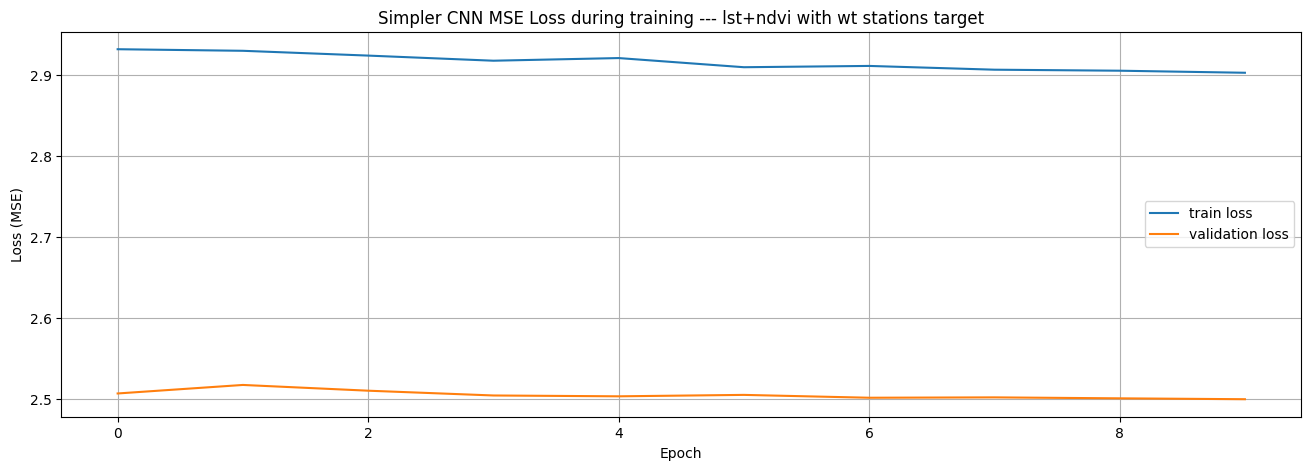

In [60]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt stations target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

### Validate and test

In [61]:
validation_prediction = simplified_cnn_model.predict(validation_input)
test_prediction = simplified_cnn_model.predict(test_input)

1/1 [==============================] - 0s 22ms/step


In [62]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [63]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

In [64]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 1.4396049
MSE : 10.791149
RMSE : 2.0030425
R² : -0.6320729237026059
MAPE (%) : 1327398.4375
MSE sample-wise : 4.0121794


Image wise metrics results

In [65]:
c = 0
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    samples_per_image = test_target.shape[1]*test_target.shape[2]
    # Flatten the true and predicted values for this sample
    y_true_flatten = test_target_flat[c:c+samples_per_image]
    y_true_mask = y_true_flatten[y_true_flatten!= 0]

    y_pred_flatten = test_prediction_flat[c:c+samples_per_image]
    y_pred_mask = y_pred_flatten[y_true_flatten!= 0]

    #print(y_true_flatten.shape,y_pred_flatten.shape)
    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


    c += samples_per_image

for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 1.4396049, 'MSE': 10.791149, 'RMSE': 2.0030425, 'R²': -0.6320729237026059, 'MAPE (%)': 1327398.4375, 'MSE sample-wise': 4.0121794}


#### Save model results

In [66]:
model_name = "CNN_pixel_wise3"
details = {'Input': '18 lst', 'Output': 'wt', 'Resolution': 256, 'Batch size': 4, 'Epochs': 10}

file_path = "../results/model_results_img_wise.xlsx"
save_excel(file_path, model_name, mean_results, excel = 'Results')

file_path = "../results/model_details.xlsx"
save_excel(file_path, model_name, details, excel = 'Details')